# Overview

This notebook utilisies the Atlite availability matrix functionality to evaluate suitable areas for renewable energy deployment. This refers to the capability to model Landuse availability. For more information see https://atlite.readthedocs.io/en/latest/examples/landuse-availability.html

# Setting up ERA5 cutout using atlite

In [1]:
import atlite
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from dask.distributed import Client, LocalCluster
from _helpers import load_gis_data, set_availability

import warnings
warnings.filterwarnings('ignore')

import pyogrio
save_availability = False
save_rooftop_availability = True

In [2]:
albers_crs = {
    "proj": "aea",  # Albers Equal Area
    "lat_1": 29.5,  # First standard parallel
    "lat_2": 45.5,  # Second standard parallel
    "lat_0": 23,    # Latitude of projection center
    "lon_0": -96,   # Longitude of projection center
    "x_0": 0,
    "y_0": 0,
    "datum": "NAD83",
    "units": "m",
    "no_defs": True
}

# Load Atlite cutouts

In [3]:
#Before running this script you must build an era5 cutout for South Africa using the atlite module
cutout = atlite.Cutout(
    path="../../cutouts/RSA-2010_22-era5.nc",
    chunks={'time': 100}
)

TypeError: Arguments 'time' and 'module' must be specified. Spatial bounds must either be passed via argument 'bounds' or 'x' and 'y'.

# Load GIS data

In [40]:
data_bundle_path = "../../data/bundle"
gis_data = load_gis_data(data_bundle_path)

Loading Eskom Supply Regions from ../../data/bundle/rsa_supply_regions.gpkg
Loading EIA applications from ../../data/bundle/REEA_OR_2023_Q3.shp
Loading REDZs from ../../data/bundle/REDZs.shp
Loading Power Corridors from ../../data/bundle/Power_corridors.shp
Loading SACAD from ../../data/bundle/SACAD_OR_2023_Q3.shp
Loading SAPAD from ../../data/bundle/SAPAD_OR_2023_Q3.shp
Loading SKA exclusion from ../../data/bundle/SKA/SKA_exclusion.shp


(-35.0, -22.0)

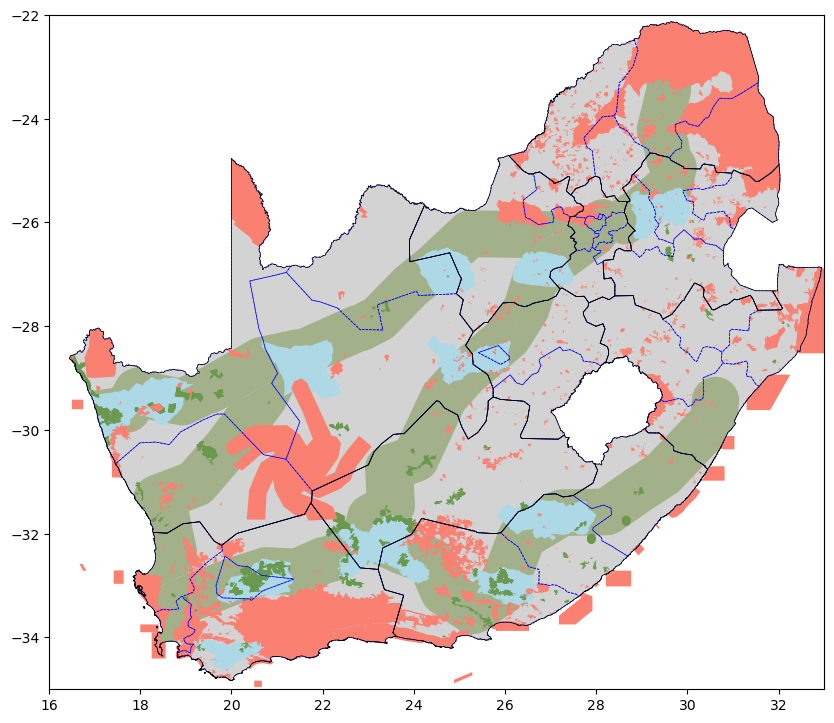

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
gis_data["supply_regions"][10].plot(ax=ax, facecolor='lightgrey', edgecolor='k', lw=0)

gis_data["corridors"].plot(ax=ax, color='#a3b18a', lw=0.5)
gis_data["redz"].plot(ax=ax, color = 'lightblue')
gis_data["eia_regions"].plot(ax=ax,color='#6a994e')
gis_data["exclusion"].plot(ax=ax, color='salmon')
gis_data["supply_regions"][34].plot(ax=ax, facecolor='none', edgecolor='b', lw=0.5, ls='--')
gis_data["supply_regions"][10].plot(ax=ax, facecolor='none', edgecolor='k', lw=0.5)

ax.set_xlim([16, 33])
ax.set_ylim([-35, -22])


# Create region exclusion zones
Exclusion zones include the following:
- DFFE SAPAD and SACAD
- Square Kilometre Array (SKA)
- Land cover classes that are unsuitable

In [42]:
if save_availability:
    for region_num in gis_data["supply_regions"].keys():
        bus_list = gis_data["supply_regions"][region_num].name.to_list()

        availability_matrix = xr.DataArray(
            coords = {
                "bus": bus_list, 
                "y": cutout.grid.y.unique(),
                "x": cutout.grid.x.unique(),
                "area": ["all", "redz", "corridors", "redz_corridors_eia"]},
            dims = ["bus", "y","x", "area"],
        )

        for area in ["all", "redz", "corridors", "redz_corridors_eia"]:
            print(f"Setting availability for {region_num} supply regions with available area: {area}")
            availability_matrix.loc[dict(area=area)] = set_availability(area, gis_data, cutout, gis_data["supply_regions"][region_num])

        availability_matrix.to_netcdf(f"availability/availability_matrix_{region_num}.nc")

<Axes: title={'center': 'area = corridors'}, xlabel='x', ylabel='y'>

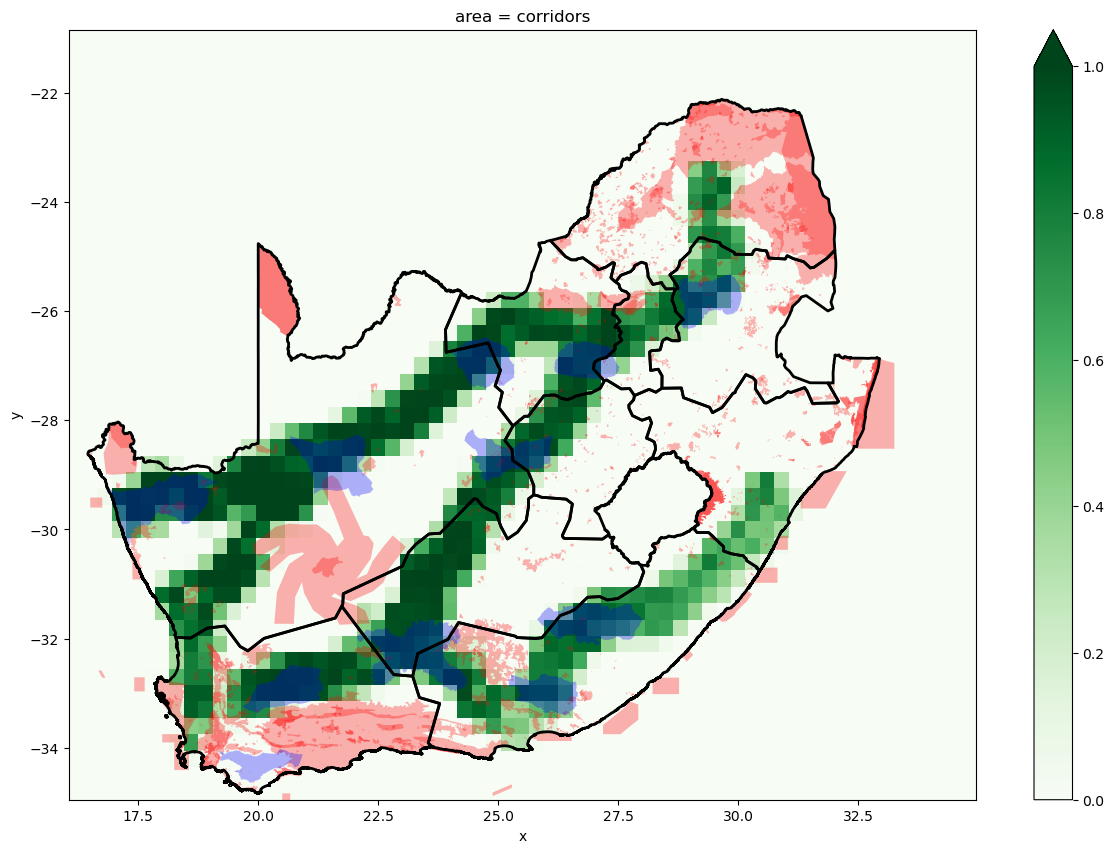

In [43]:
availability_matrix = xr.open_dataarray("availability/availability_matrix_10.nc")

fig, ax = plt.subplots(figsize=(15,10))
availability_matrix.sel(area="corridors").sum("bus").plot(ax=ax, cmap='Greens', vmin=0, vmax=1)
gis_data["exclusion"].plot(ax=ax, facecolor='red', alpha=0.3)
gis_data["redz"].plot(ax=ax, facecolor='blue',alpha=0.3)
gis_data["supply_regions"][10].plot(ax=ax, facecolor='none', edgecolor='k', lw=2)

# Rooftop solar PV availability by building area

In [44]:
if save_rooftop_availability:
    buildings = pyogrio.read_dataframe(
        "/media/pklein/1TB_SSD/Meridian Dropbox/ME Projects/03 R E S O U R C E S/Modelling data/GIS data/Buildings/hotosm_zaf_buildings_polygons_shp/hotosm_zaf_buildings_polygons.shp"
    )
    buildings = buildings.to_crs(albers_crs)
    buildings.sindex
    buildings["area"] = buildings.geometry.area

    grid = cutout.grid
    grid = grid.to_crs(albers_crs)

    buildings_in_cells = gpd.sjoin(buildings, grid, op="within")
    building_area_in_cell = buildings_in_cells.groupby(["y","x"]).sum()["area"].to_xarray()

    for region_num in gis_data["supply_regions"].keys():
        print(region_num)
        bus_list = gis_data["supply_regions"][region_num].name.to_list()
        map_cell_to_region = gpd.sjoin(grid.to_crs(albers_crs), gis_data["supply_regions"][region_num].to_crs(albers_crs), op="within")[["x", "y", "name"]]

        availability_matrix = xr.DataArray(
            coords = {
                "bus": bus_list, 
                "y": cutout.grid.y.unique(),
                "x": cutout.grid.x.unique(),
            },
            dims = ["bus", "y","x"],
        )

        for bus in bus_list:
            cell_list = map_cell_to_region[map_cell_to_region["name"] == bus][["x","y"]]
            mask = availability_matrix.coords['x'].isin(cell_list['x']) & availability_matrix.coords['y'].isin(cell_list['y'])
            selected_data = building_area_in_cell.where(mask, drop=True)
            availability_matrix.loc[dict(bus=bus, x=selected_data.coords['x'], y=selected_data.coords['y'])] = (selected_data/selected_data.sum()).values

        availability_matrix.to_netcdf(f"availability/rooftop_availability_matrix_{region_num}.nc")

1
10
27
34
159
